In [12]:
%matplotlib ipympl
import numpy as np
from pathlib import Path
import utils as utils
import harp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import aeon.io.video as video
from ipywidgets import widgets
from IPython.display import display
import re
import os
import zoneinfo
from datetime import datetime, timezone
import datetime
import matplotlib.pyplot as plt
from functools import reduce
from src.processing.detect_stage import detect_stage
from src.processing.detect_settings import detect_settings


In [14]:
#root = Path('/Volumes/harris/hypnose/rawdata/sub-020_id-072/ses-113_date-20250829/behav/2025-08-29T14-34-03')
root = Path('/Volumes/harris/hypnose/rawdata/sub-026_id-077/ses-121_date-20250908/behav/2025-09-08T12-55-53') 
# root = Path('/Volumes/harris/hypnose/rawdata/sub-026_id-077/ses-83_date-20250718/behav/2025-07-18T13-50-20') # quintuples
# root = Path('/Volumes/harris/hypnose/rawdata/sub-026_id-077/ses-69_date-20250630/behav/2025-06-30T14-03-21') # triples
#root = Path('/Volumes/harris/hypnose/rawdata/sub-026_id-077/ses-93_date-20250730/behav/2025-07-30T14-00-21')
# root = Path('/Volumes/harris/hypnose/rawdata/sub-026_id-077/ses-60_date-20250617/behav/2025-06-17T14-09-20') # doubles
# root = Path('/Volumes/harris/hypnose/rawdata/sub-025_id-076/ses-88_date-20250723/behav/2025-07-23T10-55-40')
# root = Path('/Volumes/harris/hypnose/rawdata/sub-026_id-077/ses-88_date-20250723/behav/2025-07-23T13-58-16')
stage = detect_stage(root)

Detected stage: QuintupleProbeA_Stage2_Location0
Hidden rule index: 0


In [22]:
# Load relevant data streams
behavior_reader = harp.create_reader('device_schemas/behavior.yml', epoch=harp.REFERENCE_EPOCH)
olfactometer_reader = harp.create_reader('device_schemas/olfactometer.yml', epoch=harp.REFERENCE_EPOCH)

digital_input_data = utils.load(behavior_reader.DigitalInputState, root/"Behavior")
output_set = utils.load(behavior_reader.OutputSet, root/"Behavior")
output_clear = utils.load(behavior_reader.OutputClear, root/"Behavior")
olfactometer_valves_0 = utils.load(olfactometer_reader.OdorValveState, root/"Olfactometer0")
olfactometer_valves_1 = utils.load(olfactometer_reader.OdorValveState, root/"Olfactometer1")
# # olfactometer_end_0 = utils.load(olfactometer_reader.EndValveState, root/"Olfactometer0")
# analog_data = utils.load(behavior_reader.AnalogData, root/"Behavior")
# flow_meter = utils.load(olfactometer_reader.Flowmeter, root/"Olfactometer0")
# # heartbeat = utils.load(behavior_reader.TimestampSeconds, root/"Behavior")

# # 'other' events
# video_reader = utils.Video()
# video_data = utils.load_video(video_reader, root/"VideoData")
pulse_supply_1 = utils.load(behavior_reader.PulseSupplyPort1, root/"Behavior")
pulse_supply_2 = utils.load(behavior_reader.PulseSupplyPort2, root/"Behavior")

odour_led = utils.concat_digi_events(output_clear['DOPort0'], output_set['DOPort0'])


In [16]:
# Load heartbeat 
try:
    heartbeat = utils.load(behavior_reader.TimestampSeconds, root/"Behavior")
except Exception as e:
    print(f"Error loading timestamp data: {e}")
    heartbeat = pd.DataFrame(columns=['Time', 'TimestampSeconds'])

# Reset indices for non-empty dataframes
if not heartbeat.empty:
    heartbeat.reset_index(inplace=True)


In [17]:
# Timestamp conversions
real_time_offset = pd.Timedelta(0)
if not heartbeat.empty and 'Time' in heartbeat.columns and len(heartbeat) > 0:
    try:
        real_time_str = root.name
        match = re.search(r'\d{4}-\d{2}-\d{2}T\d{2}-\d{2}-\d{2}', real_time_str)
        if match:
            real_time_str = match.group(0)
        else:
            # Try parent directory
            real_time_str = root.parent.name
            match = re.search(r'\d{4}-\d{2}-\d{2}T\d{2}-\d{2}-\d{2}', real_time_str)
            if match:
                real_time_str = match.group(0)
        
        if re.match(r'\d{4}-\d{2}-\d{2}T\d{2}-\d{2}-\d{2}', real_time_str):
            real_time_ref_utc = datetime.datetime.strptime(real_time_str, '%Y-%m-%dT%H-%M-%S')
            real_time_ref_utc = real_time_ref_utc.replace(tzinfo=datetime.timezone.utc)
            uk_tz = zoneinfo.ZoneInfo("Europe/London")
            real_time_ref = real_time_ref_utc.astimezone(uk_tz)
            
            start_time_hardware = heartbeat['Time'].iloc[0]
            start_time_dt = start_time_hardware.to_pydatetime()
            if start_time_dt.tzinfo is None:
                start_time_dt = start_time_dt.replace(tzinfo=uk_tz)
            real_time_offset = real_time_ref - start_time_dt
    except Exception as e:
        print(f"Error calculating real-time offset: {e}")

# # Apply time offset to non-empty DataFrames
# if not olfactometer_valves_0_abs.empty and 'Time' in olfactometer_valves_0_abs.columns:
#     olfactometer_valves_0_abs['Time'] = olfactometer_valves_0_abs['Time'] + real_time_offset

# Map heartbeat times if we have data
timestamp_to_time = pd.Series()
if not heartbeat.empty and 'Time' in heartbeat.columns and 'TimestampSeconds' in heartbeat.columns:
    heartbeat['Time'] = pd.to_datetime(heartbeat['Time'], errors='coerce')
    timestamp_to_time = pd.Series(data=heartbeat['Time'].values, index=heartbeat['TimestampSeconds'])

def interpolate_time(seconds):
    """Interpolate timestamps from seconds, with safety checks"""
    if timestamp_to_time.empty:
        return pd.NaT
    int_seconds = int(seconds)
    fractional_seconds = seconds % 1
    if int_seconds in timestamp_to_time.index:
        base_time = timestamp_to_time.loc[int_seconds]
        return base_time + pd.to_timedelta(fractional_seconds, unit='s')
    return pd.NaT


In [18]:
# Get experiment events 
experiment_events_dir = root / "ExperimentEvents"

if experiment_events_dir.exists():
    csv_files = list(experiment_events_dir.glob("*.csv"))
    print(f"Found {len(csv_files)} experiment event files")
    
    initiation_sequence_frames = []
    end_initiation_frames = []
    await_reward_frames = []
    reset_frames = []
    choose_random_sequence_frames = []
    sample_reward_condition_frames = []

    for csv_file in csv_files:
        try:
            ev_df = pd.read_csv(csv_file)
            print(f"Processing event file: {csv_file.name} with {len(ev_df)} rows")
            
            # Use Seconds field if available, otherwise use Time field
            if "Seconds" in ev_df.columns and not timestamp_to_time.empty:
                ev_df = ev_df.sort_values("Seconds")#.reset_index(drop=True)
                ev_df["Time"] = ev_df["Seconds"].apply(interpolate_time)
                print(f"Using Seconds column for interpolation")
            else:
                ev_df["Time"] = pd.to_datetime(ev_df["Time"], errors="coerce")
                print(f"Using Time column directly")
            
            if "Time" in ev_df.columns:
                # ev_df["Time"] = ev_df["Time"] + real_time_offset
                
                if "Value" in ev_df.columns:
                    print(f"Found Value column with values: {ev_df['Value'].unique()}")
                    eii_df = ev_df[ev_df["Value"] == "EndInitiation"].copy()
                    if not eii_df.empty:
                        print(f"Found {len(eii_df)} EndInitiation events")
                        eii_df["EndInitiation"] = True
                        end_initiation_frames.append(eii_df[["Time", "EndInitiation"]])

                    is_df = ev_df[ev_df["Value"] == "InitiationSequence"].copy()
                    if not is_df.empty:
                        print(f"Found {len(is_df)} InitiationSequence events")
                        is_df["InitiationSequence"] = True
                        initiation_sequence_frames.append(is_df[["Time", "InitiationSequence"]])

                    rs_df = ev_df[ev_df["Value"] == "Reset"].copy()
                    if not rs_df.empty:
                        print(f"Found {len(rs_df)} Reset events")
                        rs_df["Reset"] = True
                        reset_frames.append(rs_df[["Time", "Reset"]])

                    ar_df = ev_df[ev_df["Value"] == "AwaitReward"].copy()
                    if not ar_df.empty:
                        print(f"Found {len(ar_df)} AwaitReward events")
                        ar_df["AwaitReward"] = True
                        await_reward_frames.append(ar_df[["Time", "AwaitReward"]])

                    src_df = ev_df[ev_df["Value"] == "SampleRewardCondition"].copy()
                    if not src_df.empty:
                        print(f"Found {len(src_df)} SampleRewardCondition events")
                        src_df["SampleRewardCondition"] = True
                        sample_reward_condition_frames.append(src_df[["Time", "SampleRewardCondition"]])

                    crs_df = ev_df[ev_df["Value"] == "ChooseRandomSequence"].copy()
                    if not crs_df.empty:
                        print(f"Found {len(crs_df)} ChooseRandomSequence events")
                        crs_df["ChooseRandomSequence"] = True
                        choose_random_sequence_frames.append(crs_df[["Time", "ChooseRandomSequence"]])
        except Exception as e:
            print(f"Error processing event file {csv_file.name}: {e}")
else:
    print("No ExperimentEvents directory found")

# EndInitiation  
if len(end_initiation_frames) > 0:
    combined_end_initiation_df = pd.concat(end_initiation_frames, ignore_index=True)
    combined_end_initiation_df.reset_index(drop=True, inplace=True)

    print(f"Combined {len(combined_end_initiation_df)} EndInitiation events")
else:
    combined_end_initiation_df = pd.DataFrame(columns=["Time", "EndInitiation"])
    print("No EndInitiation events found - cannot identify trial endings")

# AwaitReward
if len(await_reward_frames) > 0:
    combined_await_reward_df = pd.concat(await_reward_frames, ignore_index=True)
    combined_await_reward_df.reset_index(drop=True, inplace=True)

    print(f"Combined {len(combined_await_reward_df)} AwaitReward events")
else:
    combined_await_reward_df = pd.DataFrame(columns=["Time", "AwaitReward"])
    print("No AwaitReward events found - cannot identify trial endings")

# InitiationSequence
if len(initiation_sequence_frames) > 0:
    combined_initiation_sequence_df = pd.concat(initiation_sequence_frames, ignore_index=True)
    combined_initiation_sequence_df.reset_index(drop=True, inplace=True)

    print(f"Combined {len(combined_initiation_sequence_df)} InitiationSequence events")
else:
    combined_initiation_sequence_df = pd.DataFrame(columns=["Time", "InitiationSequence"])
    print("No InitiationSequence events found - cannot identify trial endings")

# Reset
if len(reset_frames) > 0:
    combined_reset_df = pd.concat(reset_frames, ignore_index=True)
    combined_reset_df.reset_index(drop=True, inplace=True)

    print(f"Combined {len(combined_reset_df)} Reset events")
else:
    combined_reset_df = pd.DataFrame(columns=["Time", "Reset"])
    print("No Reset events found - cannot identify trial endings")

# ChooseRandomSequence
if len(choose_random_sequence_frames) > 0:
    combined_choose_random_sequence_df = pd.concat(choose_random_sequence_frames, ignore_index=True)
    combined_choose_random_sequence_df.reset_index(drop=True, inplace=True)

    print(f"Combined {len(combined_choose_random_sequence_df)} ChooseRandomSequence events")
else:
    combined_choose_random_sequence_df = pd.DataFrame(columns=["Time", "ChooseRandomSequence"])
    print("No ChooseRandomSequence events found - cannot identify trial endings")

# SampleRewardCondition
if len(sample_reward_condition_frames) > 0:
    combined_sample_reward_condition_df = pd.concat(sample_reward_condition_frames, ignore_index=True)
    combined_sample_reward_condition_df.reset_index(drop=True, inplace=True)

    print(f"Combined {len(combined_sample_reward_condition_df)} SampleRewardCondition events")
else:
    combined_sample_reward_condition_df = pd.DataFrame(columns=["Time", "SampleRewardCondition"])
    print("No SampleRewardCondition events found - cannot identify trial endings")


Found 5 experiment event files
Processing event file: ExperimentEvents_1904-02-05T03-00-00.csv with 447 rows
Using Seconds column for interpolation
Found Value column with values: ['EndInitiation' 'AwaitReward' 'Reset' 'ChooseRandomSequence'
 'SampleRewardCondition' 'InitiationSequence']
Found 78 EndInitiation events
Found 78 InitiationSequence events
Found 78 Reset events
Found 57 AwaitReward events
Found 78 SampleRewardCondition events
Found 78 ChooseRandomSequence events
Processing event file: ExperimentEvents_1904-02-05T06-00-00.csv with 251 rows
Using Seconds column for interpolation
Found Value column with values: ['EndInitiation' 'AwaitReward' 'Reset' 'ChooseRandomSequence'
 'SampleRewardCondition' 'InitiationSequence']
Found 45 EndInitiation events
Found 45 InitiationSequence events
Found 45 Reset events
Found 26 AwaitReward events
Found 45 SampleRewardCondition events
Found 45 ChooseRandomSequence events
Processing event file: ExperimentEvents_1904-02-05T02-00-00.csv with 165 

In [19]:
combined_end_initiation_df.set_index("Time", inplace=True) 

In [20]:
# Olfactometer - odour map 
olfactometer_valves = {
    0: olfactometer_valves_0,
    1: olfactometer_valves_1,
}

session_settings, session_schema = detect_settings(root)
olf_valves0 = [cmd.valvesOpenO0 for cmd in session_settings.metadata.iloc[0].olfactometerCommands]
olf_valves1 = [cmd.valvesOpenO1 for cmd in session_settings.metadata.iloc[0].olfactometerCommands]

olf_command_idx = {
    f'0{val}': next(i for i, lst in enumerate(olf_valves0) if val in lst)
    for val in range(4)
} | {
    f'1{val}': next(i for i, lst in enumerate(olf_valves1) if val in lst)
    for val in range(4)
}                

odour_to_olfactometer_map = [[] for _ in range(len(olfactometer_valves))]
for cmd, idx in olf_command_idx.items():
    olf_id = int(cmd[0])
    
    odour_to_olfactometer_map[olf_id].append(session_settings.metadata.iloc[0].olfactometerCommands[idx].name)
print(odour_to_olfactometer_map)

[['OdorA', 'OdorE', 'OdorC', 'OdorD'], ['OdorB', 'OdorF', 'OdorG', 'Purge']]


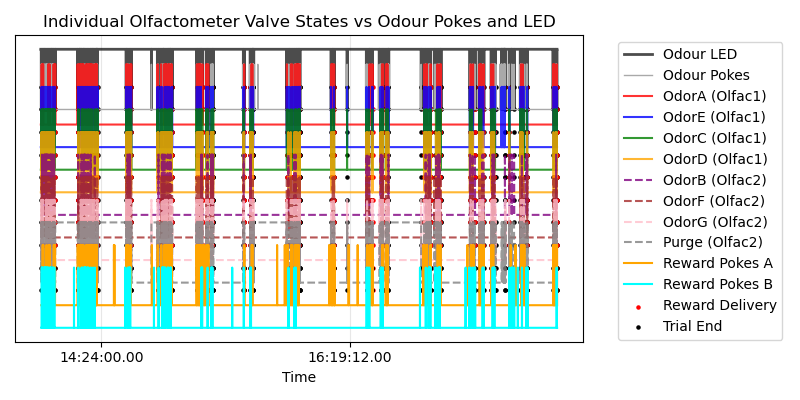

In [21]:
# Plot each individual olfactometer valve state with different colors against pokes
plt.figure(figsize=(8, 4))

event_df = combined_end_initiation_df

# Reward delivery data
pulse_supply_2['PulseSupplyPort2'] = True
pulse_supply_1['PulseSupplyPort1'] = True
        
# Define colors for different valves
valve_colors = ['red', 'blue', 'green', 'orange', 'purple', 'brown', 'pink', 'gray']

# Plot odour LED and pokes first
plt.step(odour_led.index + real_time_offset, odour_led * 0.8, where='post', c='black', linewidth=2, label='Odour LED', alpha=0.7)
plt.step(digital_input_data.index + real_time_offset, digital_input_data['DIPort0'] * 0.6, where='post', c='darkgray', linewidth=1, label='Odour Pokes')
# plt.step(digital_input_data.index + real_time_offset, digital_input_data['DIPort1'] * 0.6, where='post', c='orange', linewidth=1, label='Reward Pokes A')
# plt.step(digital_input_data.index + real_time_offset, digital_input_data['DIPort2'] * 0.6, where='post', c='cyan', linewidth=1, label='Reward Pokes B')

# Plot individual valves from olfactometer 0 and EndInitiation events and reward delivery
valve_offset = -0.2
for i, valve_col in enumerate(olfactometer_valves_0.columns):
        valve_data = olfactometer_valves_0[valve_col]
        color = valve_colors[i % len(valve_colors)]
        plt.step(valve_data.index + real_time_offset, valve_data * 0.8 + valve_offset, where='post', 
                c=color, linewidth=1.5, label=f'{odour_to_olfactometer_map[0][i]} (Olfac1)', alpha=0.8)
        plt.scatter(event_df.index + real_time_offset, event_df * 0.5 + valve_offset, s=5, c='k')
        # plt.scatter(event_df.index[112] + real_time_offset, event_df.iloc[112]['EndInitiation'] * 0.5 + valve_offset, s=20, c='b')

        plt.scatter(pulse_supply_1['PulseSupplyPort1'].index + real_time_offset, pulse_supply_1['PulseSupplyPort1'] * 0.5 + valve_offset, s=5, c='r')
        plt.scatter(pulse_supply_2['PulseSupplyPort2'].index + real_time_offset, pulse_supply_2['PulseSupplyPort2'] * 0.5 + valve_offset, s=5, c='r')
        valve_offset -= 0.3

# Plot individual valves from olfactometer 1 and EndInitiation events and reward delivery
for i, valve_col in enumerate(olfactometer_valves_1.columns):
        valve_data = olfactometer_valves_1[valve_col]
        color = valve_colors[(i + len(olfactometer_valves_0.columns)) % len(valve_colors)]
        plt.step(valve_data.index + real_time_offset, valve_data * 0.8 + valve_offset, where='post', 
                c=color, linewidth=1.5, label=f'{odour_to_olfactometer_map[1][i]} (Olfac2)', alpha=0.8, linestyle='--')
        plt.scatter(event_df.index + real_time_offset, event_df * 0.5 + valve_offset, s=5, c='k')
        plt.scatter(pulse_supply_1['PulseSupplyPort1'].index + real_time_offset, pulse_supply_1['PulseSupplyPort1'] * 0.5 + valve_offset, s=5, c='r')
        plt.scatter(pulse_supply_2['PulseSupplyPort2'].index + real_time_offset, pulse_supply_2['PulseSupplyPort2'] * 0.5 + valve_offset, s=5, c='r')
        valve_offset -= 0.3

# Plot reward pokes and reward delivery
for i, di_col in enumerate(digital_input_data):
        if di_col == 'DIPort1':
                DIPort_data = digital_input_data[di_col]
                plt.step(DIPort_data.index + real_time_offset, DIPort_data * 0.8 + valve_offset, where='post', c='orange', linewidth=1.5, label='Reward Pokes A')
                # plt.step(DIPort_data.index + real_time_offset, DIPort_data * 0.8 + valve_offset, where='post', 
                # c='black', linewidth=1.5, label=f'RewardPort {di_col}', alpha=0.8, linestyle='--')
                plt.scatter(pulse_supply_1['PulseSupplyPort1'].index + real_time_offset, pulse_supply_1['PulseSupplyPort1'] * 0.5 + valve_offset, s=5, c='r')
                plt.scatter(pulse_supply_2['PulseSupplyPort2'].index + real_time_offset, pulse_supply_2['PulseSupplyPort2'] * 0.5 + valve_offset, s=5, c='r')
                plt.scatter(event_df.index + real_time_offset, event_df * 0.5 + valve_offset, s=5, c='k')
                valve_offset -= 0.3

        elif di_col == 'DIPort2':
                DIPort_data = digital_input_data[di_col]
                plt.step(DIPort_data.index + real_time_offset, DIPort_data * 0.8 + valve_offset, where='post', c='cyan', linewidth=1.5, label='Reward Pokes B')
                # plt.step(DIPort_data.index + real_time_offset, DIPort_data * 0.8 + valve_offset, where='post', 
                # c='black', linewidth=1.5, label=f'RewardPort {di_col}', alpha=0.8, linestyle='--')
                plt.scatter(pulse_supply_1['PulseSupplyPort1'].index + real_time_offset, pulse_supply_1['PulseSupplyPort1'] * 0.5 + valve_offset, s=5, c='r')
                plt.scatter(pulse_supply_2['PulseSupplyPort2'].index + real_time_offset, pulse_supply_2['PulseSupplyPort2'] * 0.5 + valve_offset, s=5, c='r', label='Reward Delivery')
                plt.scatter(event_df.index + real_time_offset, event_df * 0.5 + valve_offset, s=5, c='k', label='Trial End')
                valve_offset -= 0.3

# Format x-axis time labels
class TwoDigitMsFormatter(mdates.DateFormatter):
    def __call__(self, x, pos=0):
        dt = mdates.num2date(x)
        # Format as HH:MM:SS.xx where xx is two-digit ms
        return dt.strftime('%H:%M:%S.') + f"{int(dt.microsecond / 10000):02d}"

ax = plt.gca()
ax.xaxis.set_major_formatter(TwoDigitMsFormatter('%H:%M:%S.%f'))

def update_ticks(event):
    ax = event.canvas.figure.axes[0]
    ax.xaxis.set_major_locator(ticker.MaxNLocator(nbins=3))
    event.canvas.draw_idle()

# Attach to the zoom/pan events
plt.gcf().canvas.mpl_connect('draw_event', update_ticks)

# Optional: Call once for the initial state
update_ticks(type('event', (object,), {'canvas': plt.gcf().canvas})())

plt.xlabel('Time')
plt.title('Individual Olfactometer Valve States vs Odour Pokes and LED')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.yticks([])  # Removes y-axis tick marks and labels
plt.tight_layout()

plt.show()
